In [1]:
# для автозагрузки изменений в модулях
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../lib')
import Handlers as hd

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# sns.set_theme('notebook')
sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
df = pd.read_csv('data/ab_data.zip', parse_dates=['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    290482 non-null  int64         
 1   timestamp  290482 non-null  datetime64[ns]
 2   group      290482 non-null  object        
 3   converted  290482 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 8.9+ MB


In [4]:
df

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1
...,...,...,...,...
290477,751197,2017-01-03,A,0
290478,945152,2017-01-12,A,0
290479,734608,2017-01-22,A,0
290480,697314,2017-01-15,A,0


In [5]:
daily_data = (
    df.groupby(['timestamp', 'group'])
    .agg({'user_id': 'count', 'converted': 'sum'})
    .reset_index()
    .rename(columns={'user_id': 'users_count'})
)
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


In [6]:
daily_data["conversion"] = daily_data.converted / daily_data.users_count * 100

Чему была равна конверсия (в процентах) в группе А 5 января 2017 года?

In [7]:
conv = daily_data[
    (daily_data["timestamp"] == "2017-01-05") & (daily_data["group"] == "A")
]["conversion"].values[0]
print(f"Конверсия для группы А 2017-01-05 составила {conv:.2f} %")

Конверсия для группы А 2017-01-05 составила 12.32 %


In [8]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    46 non-null     datetime64[ns]
 1   group        46 non-null     object        
 2   users_count  46 non-null     int64         
 3   converted    46 non-null     int64         
 4   conversion   46 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.9+ KB


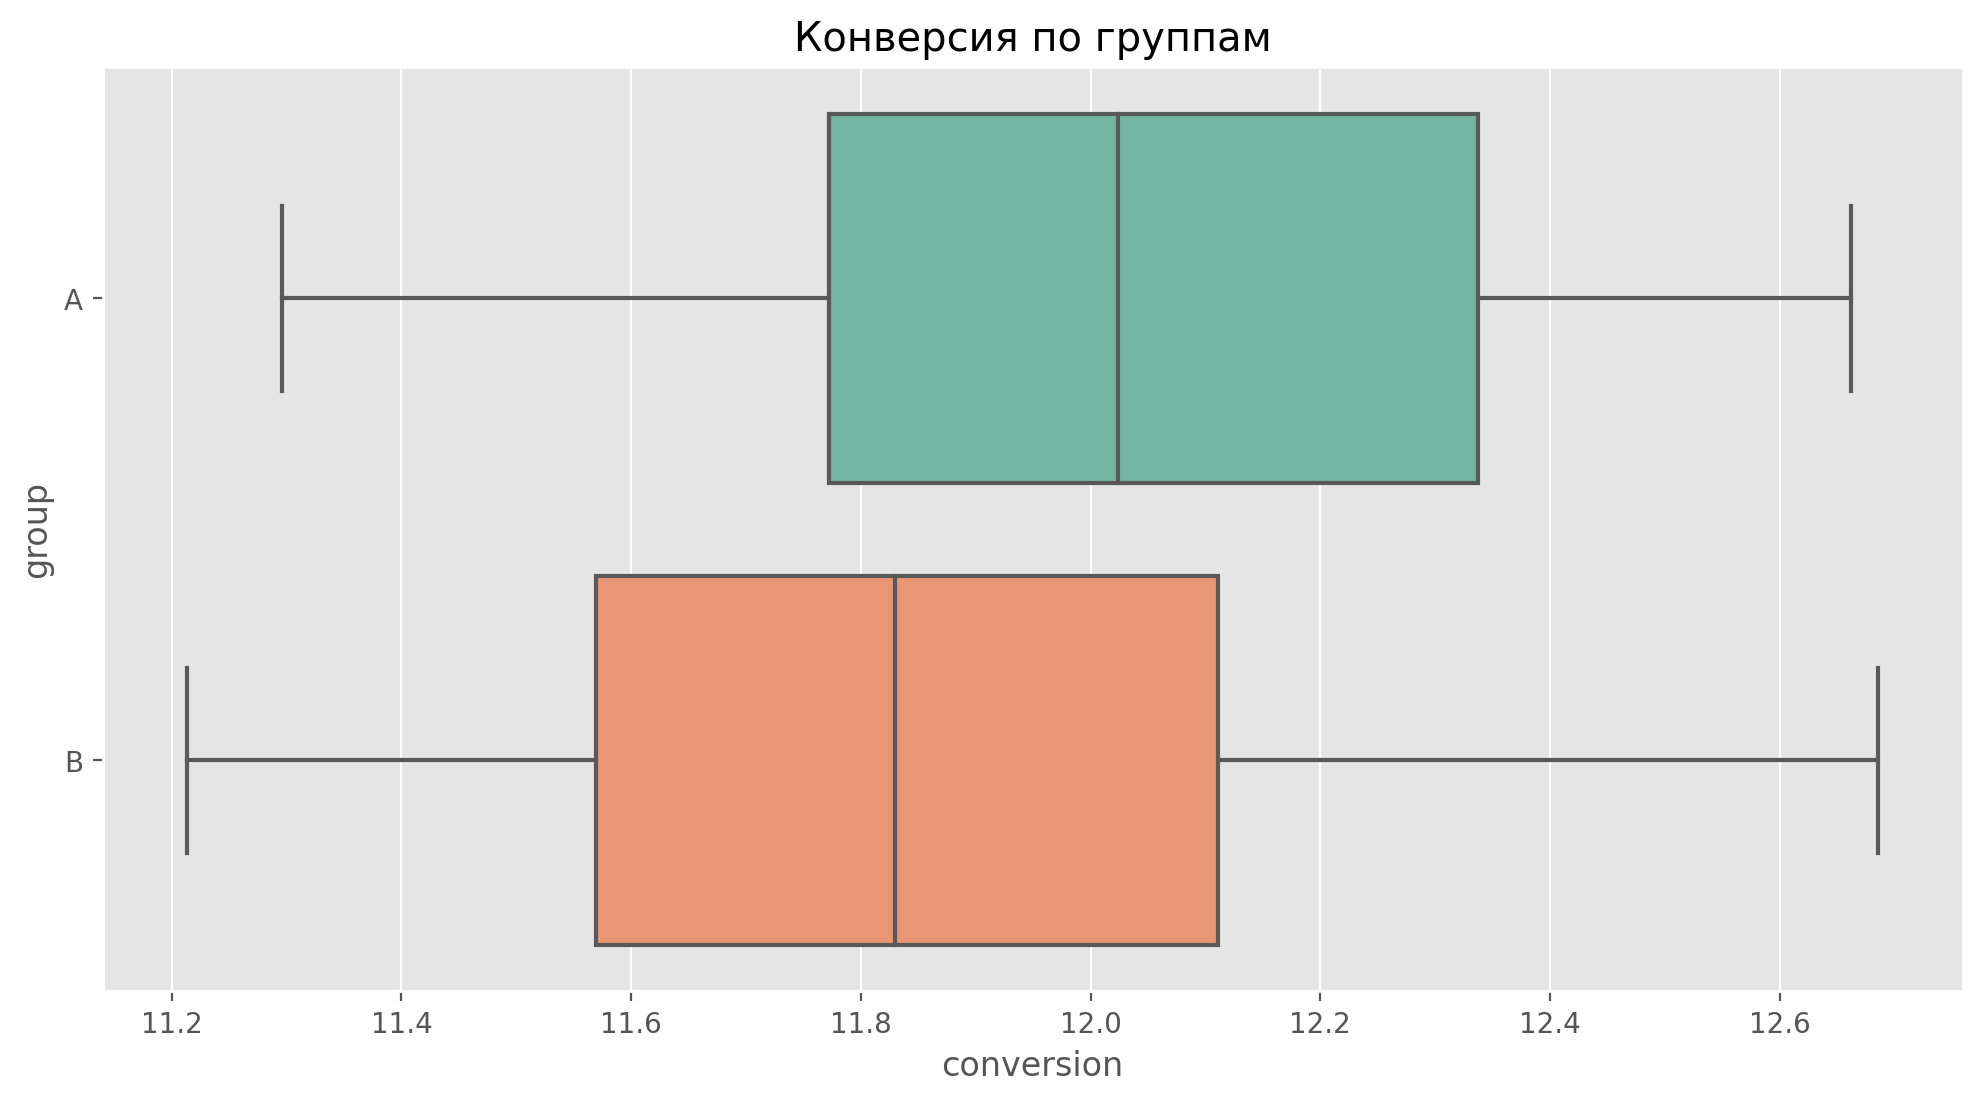

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax);
ax.set_title('Конверсия по группам');

In [10]:
conversion_piv = daily_data.groupby("group")["conversion"].agg(["mean", "median"])
conversion_piv

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Посмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени

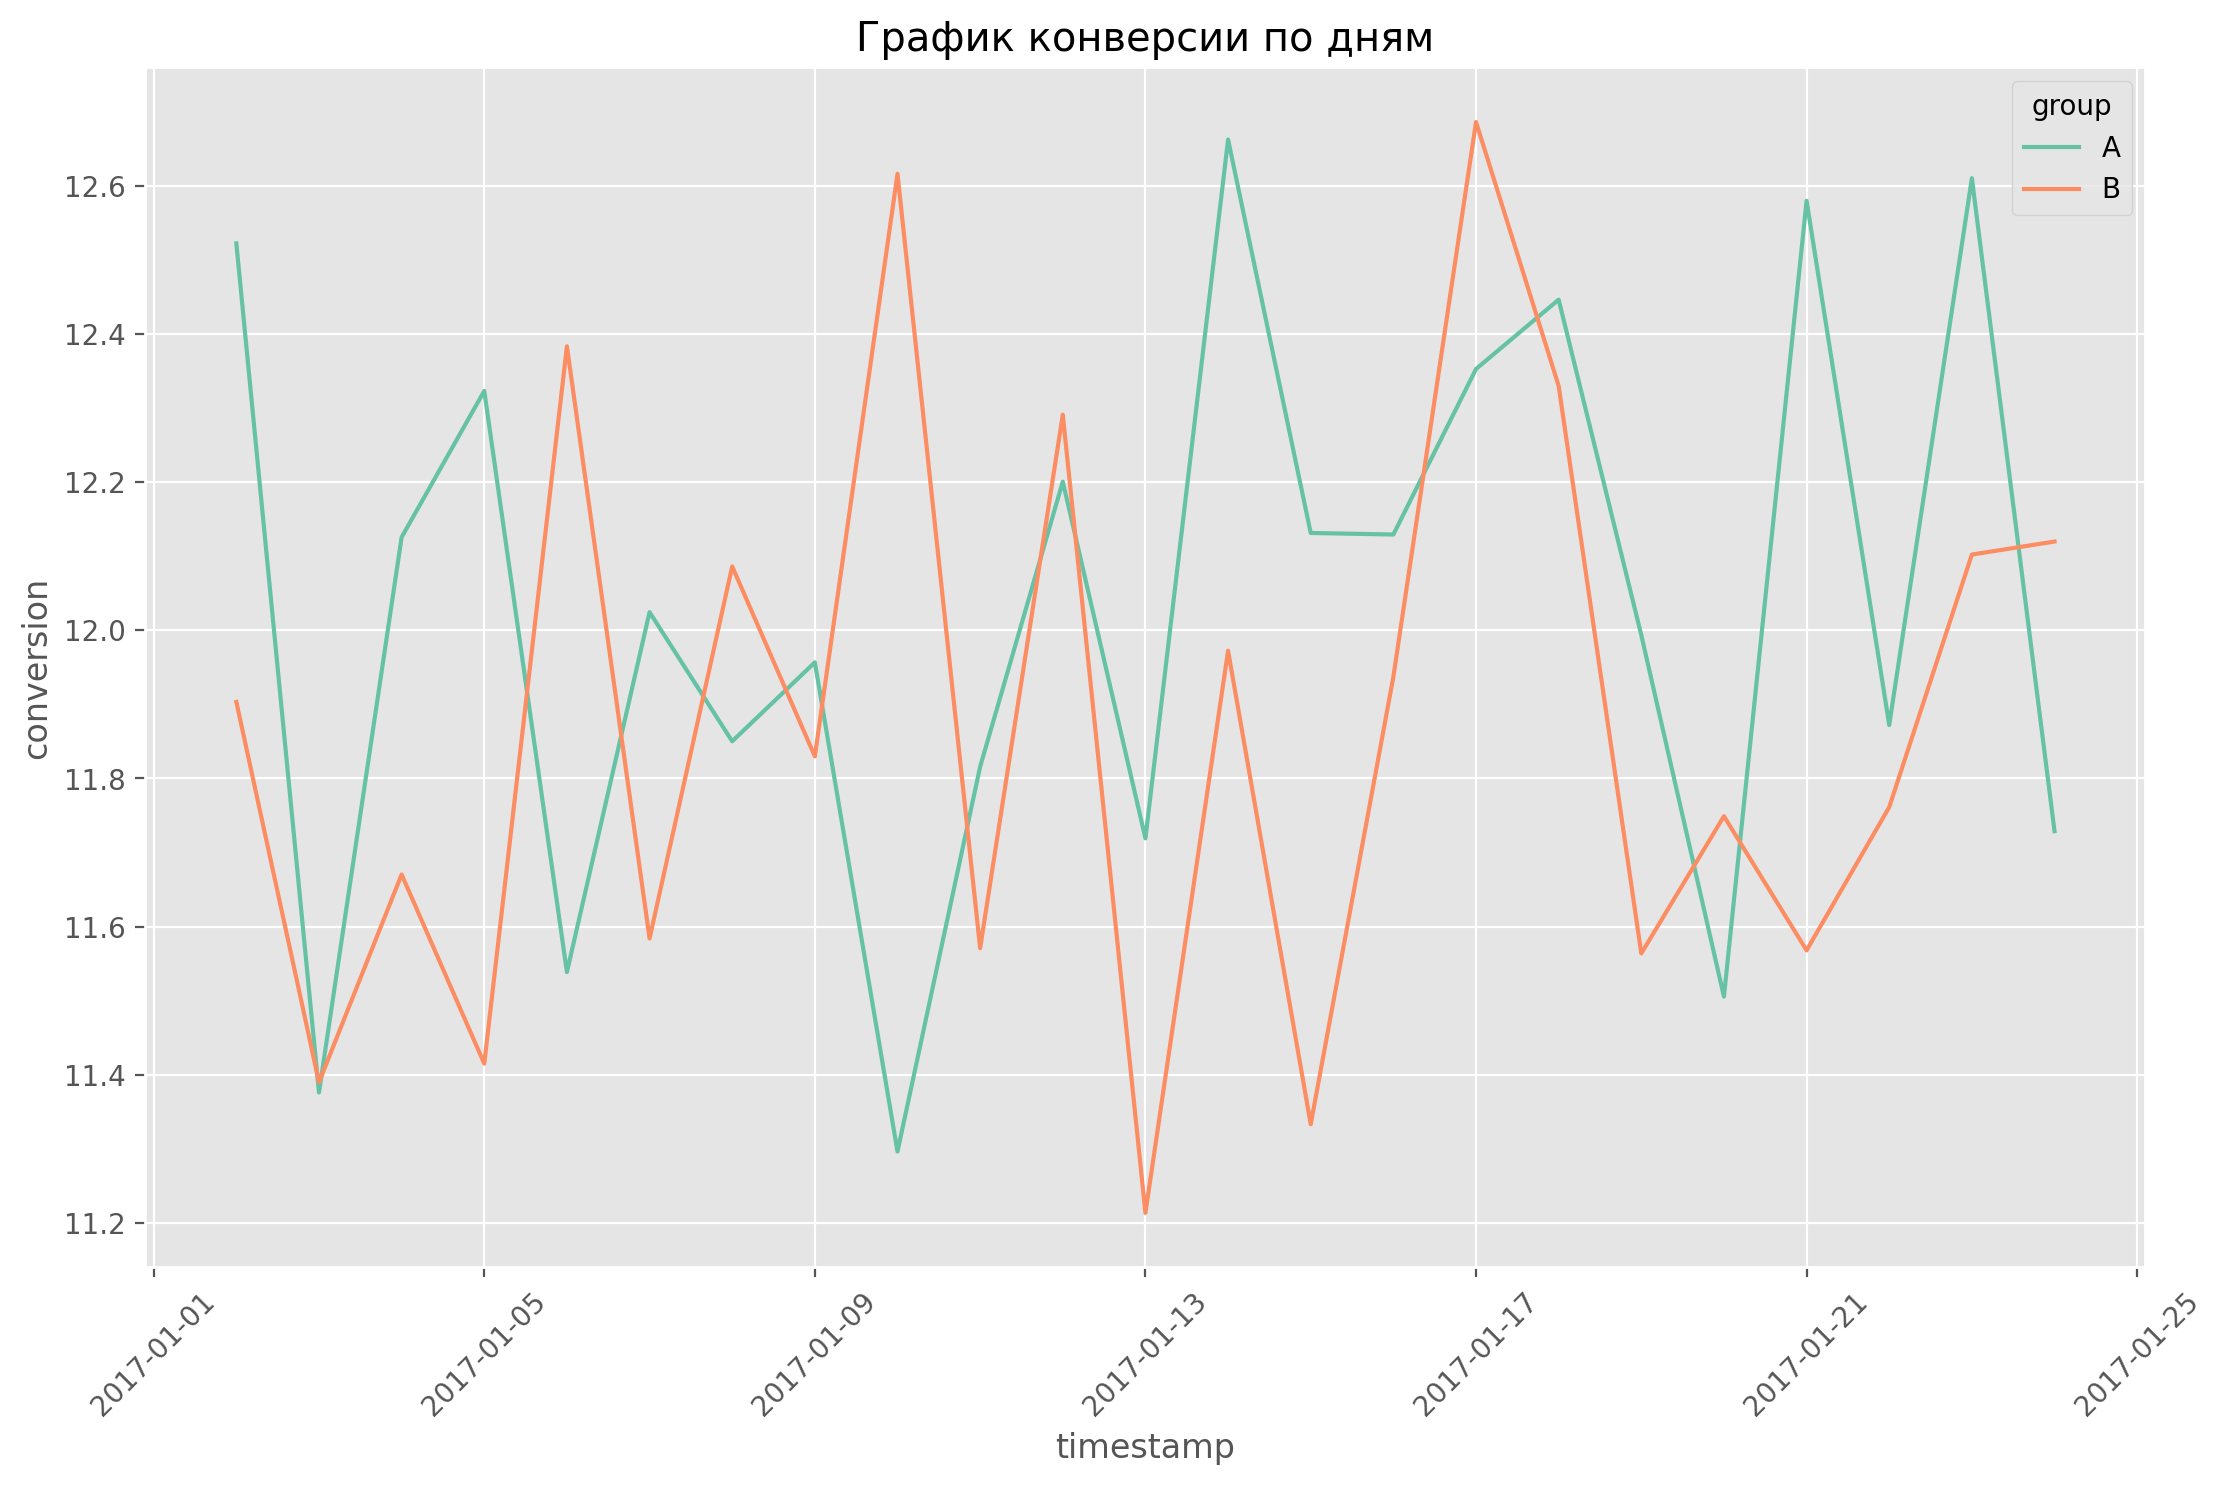

In [11]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
ax.set_title('График конверсии по дням')
ax.xaxis.set_tick_params(rotation=45)
# ax.grid(True);

### Расчет кумулятивных метрик

In [12]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A'].copy()
# считаем кумулятивное количество посетителей
daily_data_a['cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
daily_data_a[['timestamp', 'users_count', 'cum_users_count']]

,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031
10,2017-01-07,6595,35626
12,2017-01-08,6692,42318
14,2017-01-09,6624,48942
16,2017-01-10,6657,55599
18,2017-01-11,6686,62285


In [13]:
# вычисляем кумулятивную сумму количества посетителей
daily_data["cum_users_count"] = daily_data.groupby(["group"])["users_count"].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data["cum_converted"] = daily_data.groupby(["group"])["converted"].cumsum()
# вычисляем кумулятивную конверсию
daily_data["cum_conversion"] = (
    daily_data["cum_converted"] / daily_data["cum_users_count"] * 100
)
daily_data

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806
5,2017-01-04,B,6538,763,11.670236,16006,1856,11.595652
6,2017-01-05,A,6419,791,12.322792,22427,2694,12.012307
7,2017-01-05,B,6509,743,11.414964,22515,2599,11.543416
8,2017-01-06,A,6604,762,11.538462,29031,3456,11.904516
9,2017-01-06,B,6735,834,12.383073,29250,3433,11.736752


Построим графики кумулятивной конверсии по дням в каждой группе

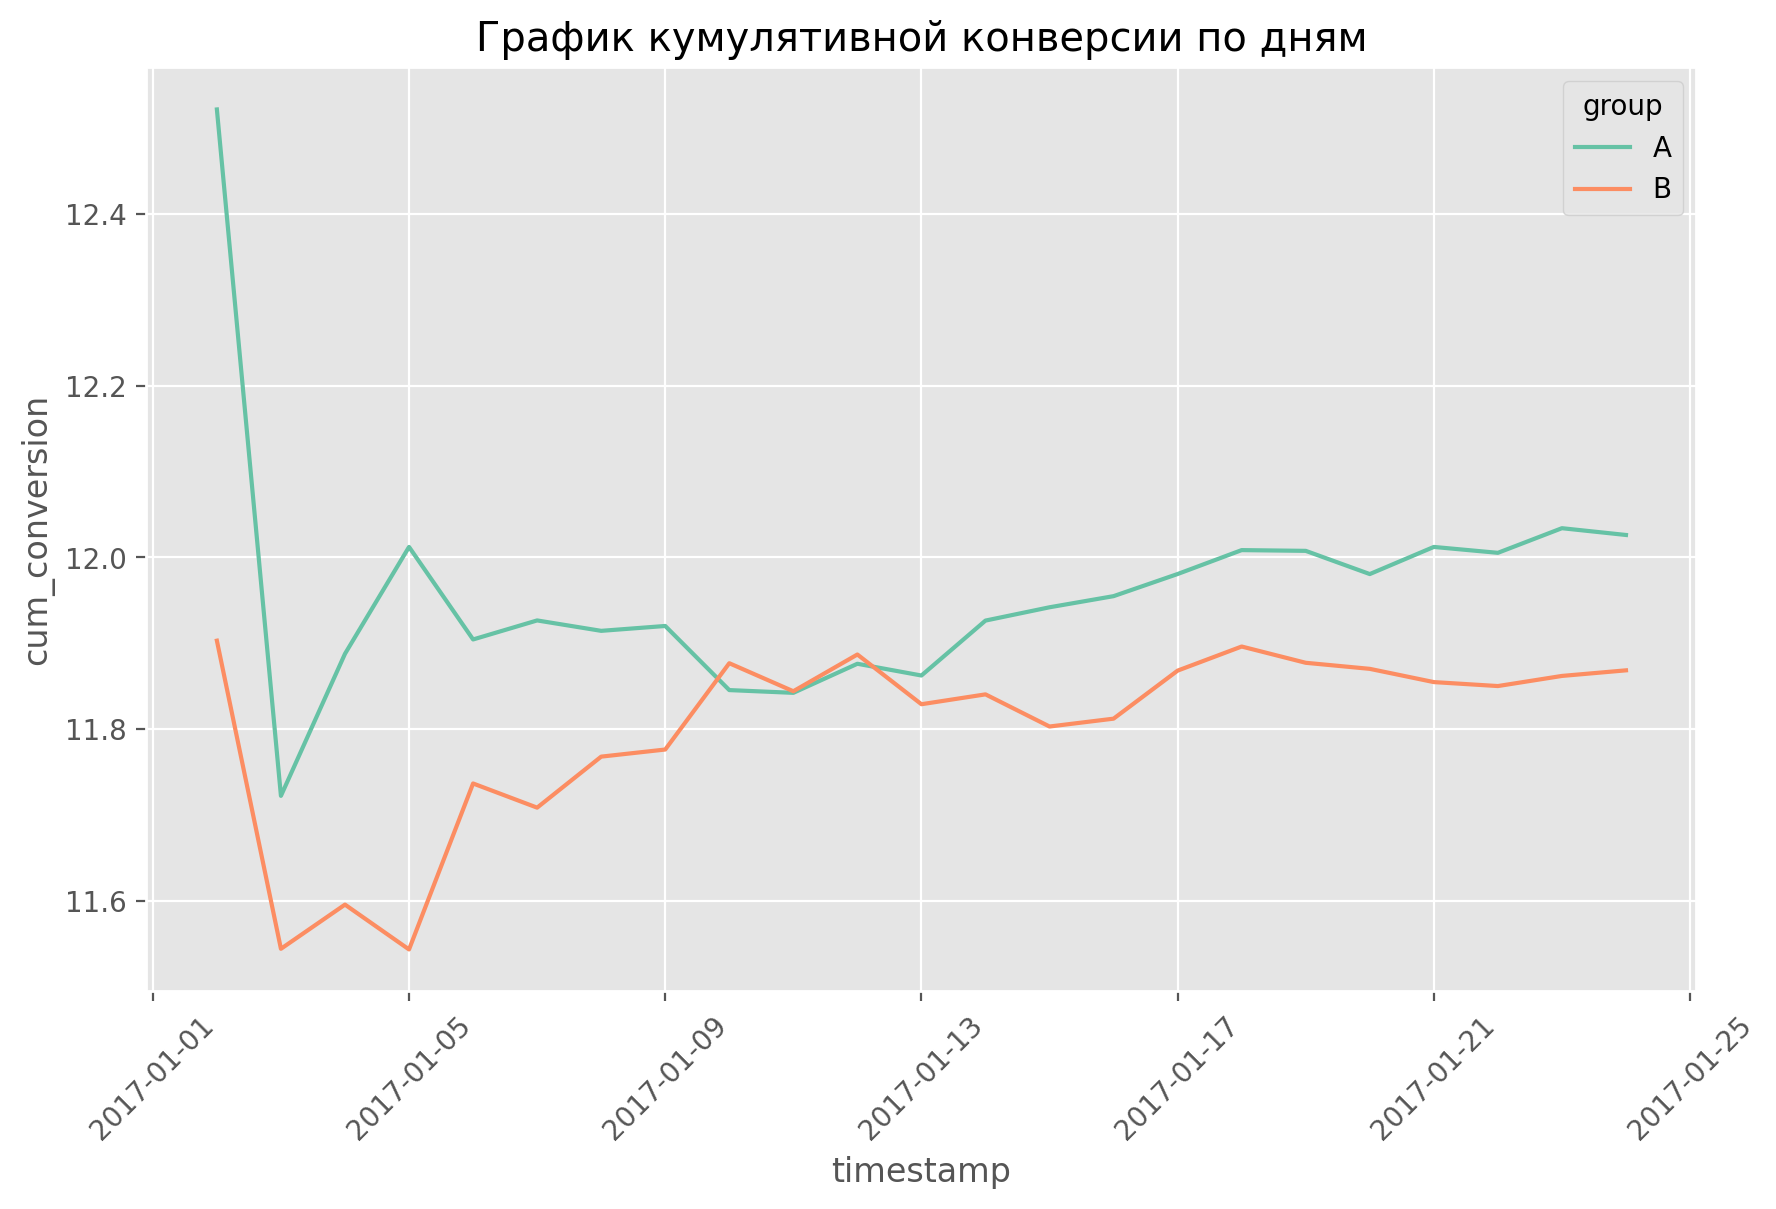

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation=45);

# Статистические тесты
Сначала подготовим данные к проведению статистических тестов. Для этого нам нужно рассчитать количество пользователей, совершивших конверсию, и общее количество пользователей в каждой контрольной и тестовой группах.

In [15]:
df

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1
...,...,...,...,...
290477,751197,2017-01-03,A,0
290478,945152,2017-01-12,A,0
290479,734608,2017-01-22,A,0
290480,697314,2017-01-15,A,0


In [16]:
converted_piv = df.groupby('group')['converted'].agg(['sum', 'count'])
converted_piv

,sum,count
group,,
A,17467,145241
B,17238,145241


### Z-ТЕСТ ДЛЯ ПРОПОРЦИЙ

In [17]:
#!pip install statsmodels
from statsmodels.stats.proportion import proportions_ztest

In [18]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.19
У нас нет оснований отвергнуть нулевую гипотезу


If you're testing whether the proportion in group 1 is larger than in group 2, you'd choose 'larger'.

In [19]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='larger' # правосторонняя альтернативная гипотеза
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.095
У нас нет оснований отвергнуть нулевую гипотезу


### X<sup>2</sup>-ТЕСТ ДЛЯ ПРОПОРЦИЙ

In [20]:
from statsmodels.stats.proportion import proportions_chisquare

In [21]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'] # общее число наблюдений
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.19
У нас нет оснований отвергнуть нулевую гипотезу


# ПАРАМЕТРИЧЕСКИЕ ТЕСТЫ
Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. 

Гипотеза заключается в том, что тёмная тема более привлекательна для посетителей, поэтому их сильнее заинтересует наш сайт, 

следовательно, они проведут на нём больше времени. Уровень значимости равен 0.05.

In [22]:
# !pip install openpyxl

In [23]:
time_data = pd.read_excel('data/time_data.xlsx')
time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time(A)  30 non-null     float64
 1   time(B)  30 non-null     float64
dtypes: float64(2)
memory usage: 612.0 bytes


In [24]:
time_data

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4
5,453.0,600.4
6,591.0,531.6
7,484.5,549.2
8,484.5,773.2
9,562.5,437.2


In [25]:
time_data.agg(['mean', 'median'])

,time(A),time(B)
mean,492.90,595.406667
median,482.25,600.400000


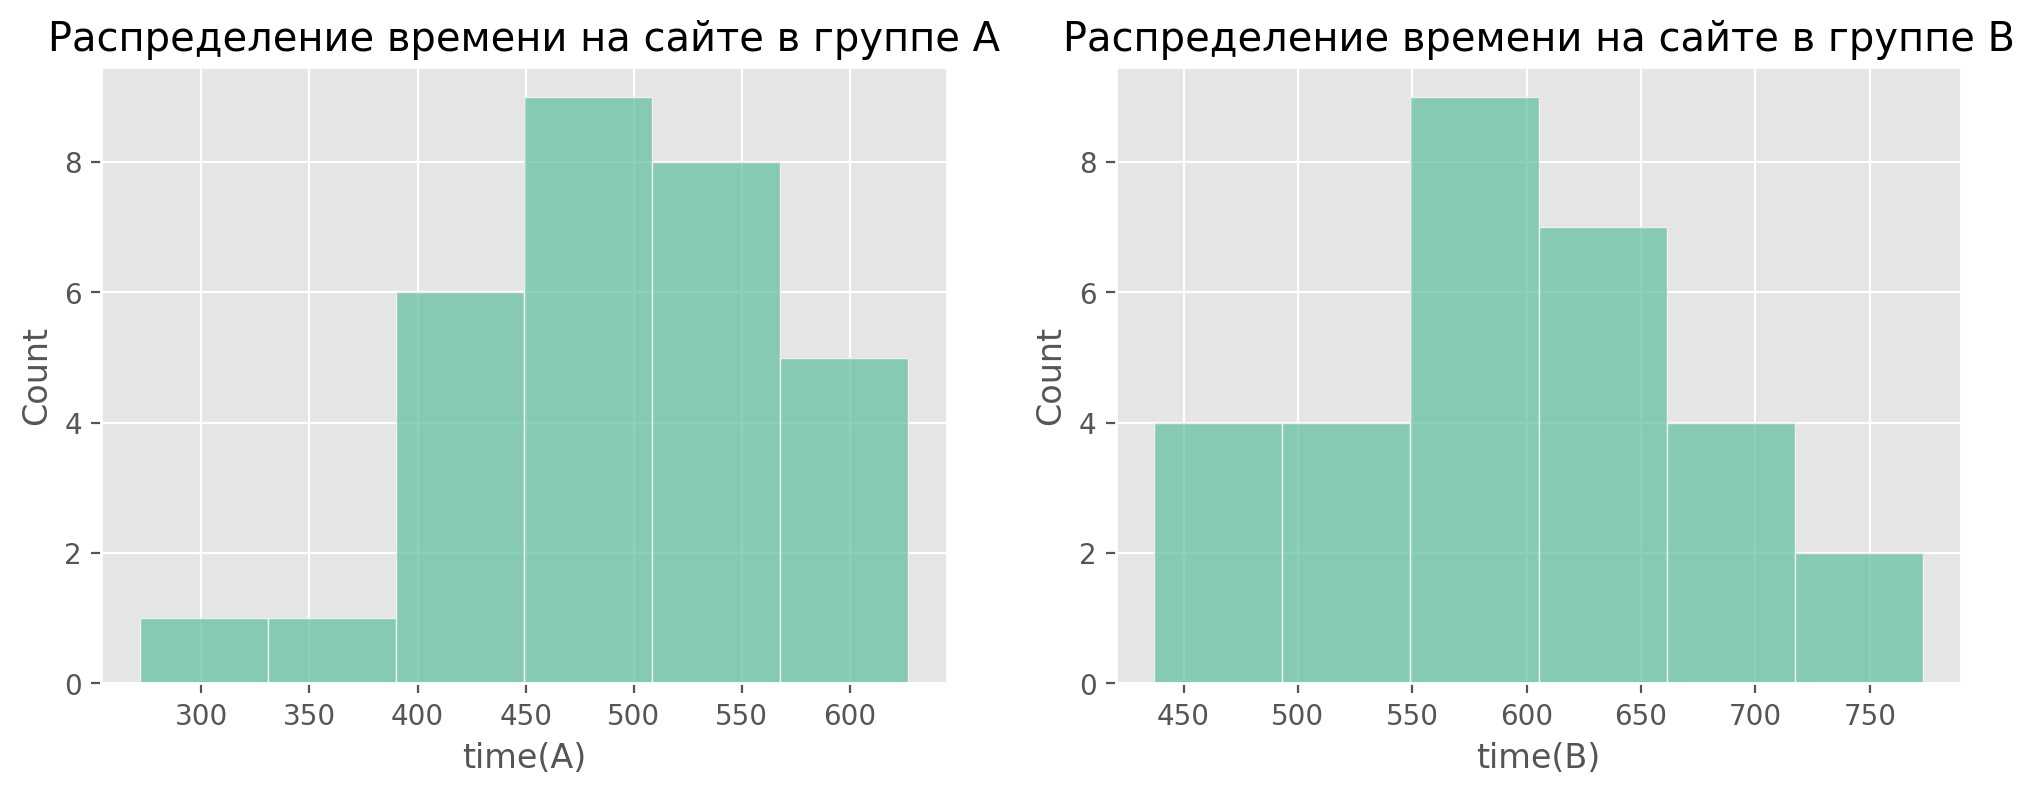

In [26]:
# создаём два графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
# задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

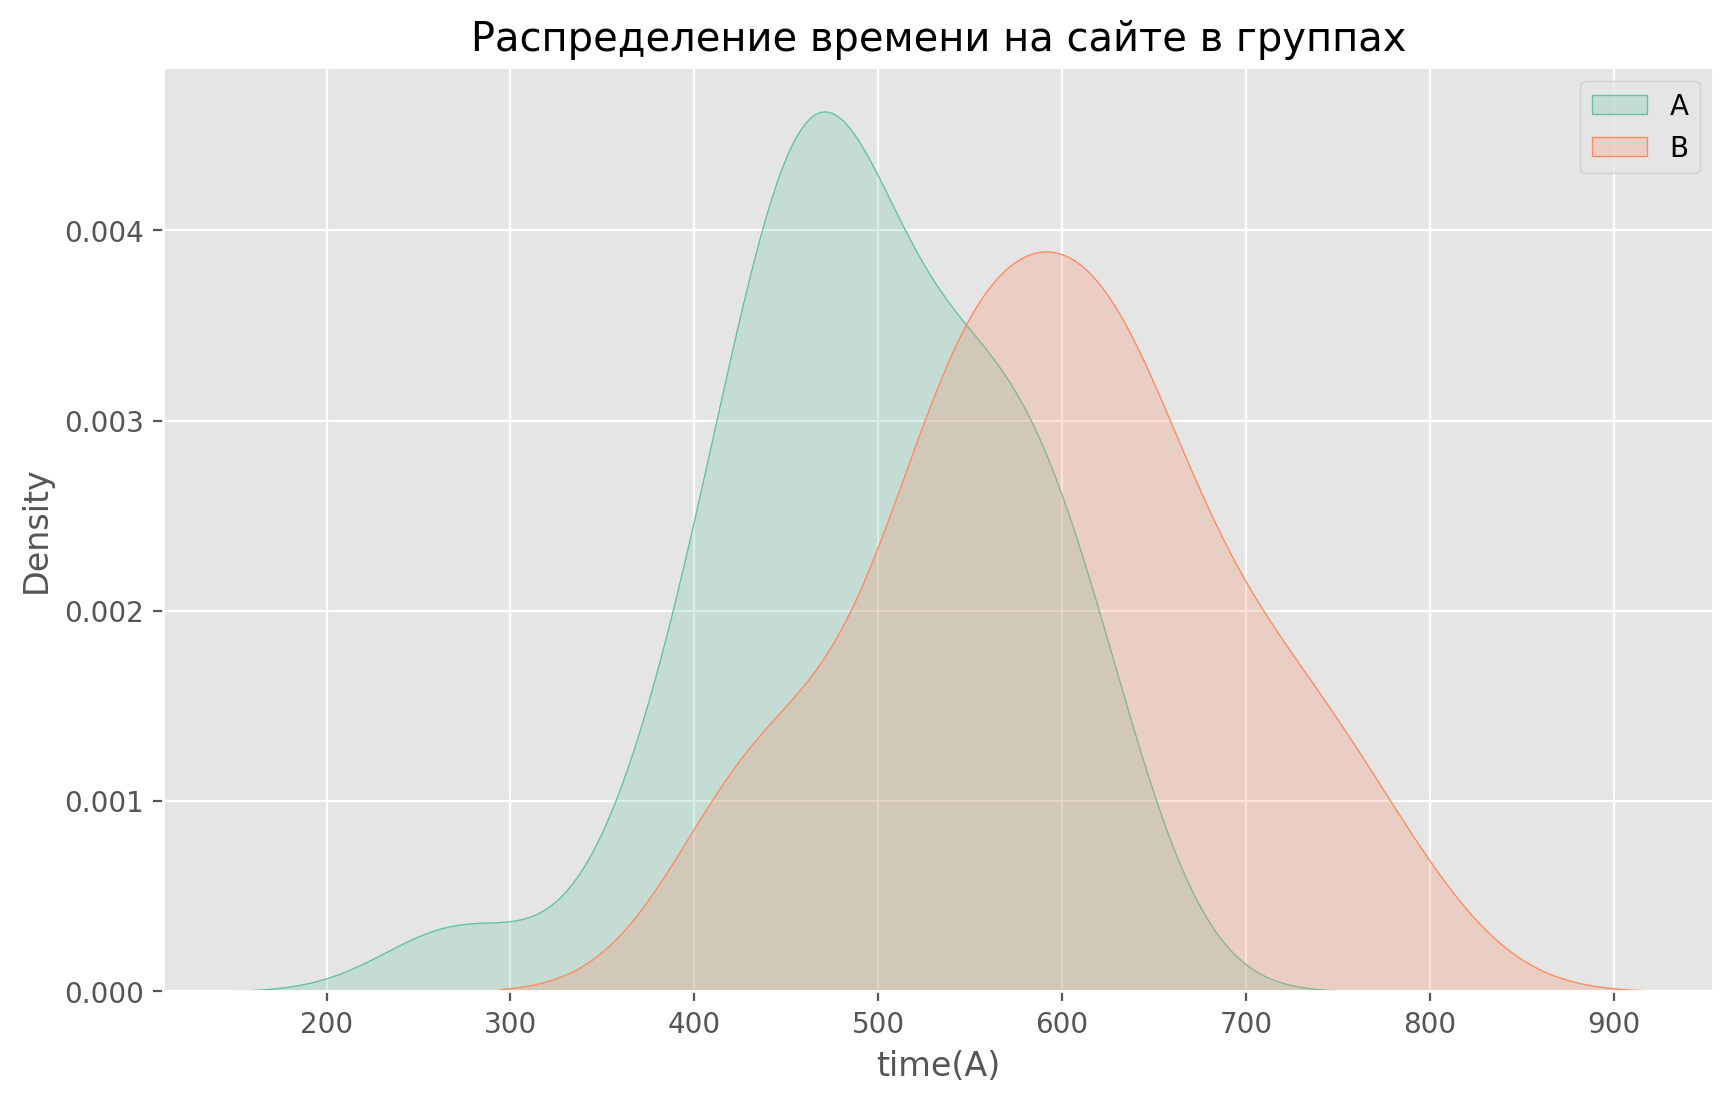

In [27]:
# создаём два графика размером 12x4
fig, axes = plt.subplots(figsize=(10, 6))
# строим гистограмму для времени на сайте в каждой группе
sns.kdeplot(x='time(A)', data=time_data, label='A', fill=True)
sns.kdeplot(x='time(B)', data=time_data, label='B', fill=True)
axes.set_title('Распределение времени на сайте в группах')
axes.legend();

Гистограммы напоминают нормальное распределение. Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро — Уилка. Для этого используем функцию shapiro() из модуля scipy.stats:

In [28]:
hd.shapiro_normal_test(time_data['time(A)'])
print()
hd.shapiro_normal_test(time_data['time(B)'])

Test on normal distribution: 0.9658262133598328
P-Value: 0.43211615085601807
Normal distribution

Test on normal distribution: 0.9440224766731262
P-Value: 0.1167508140206337
Normal distribution


In [29]:
hd.pirson_normal_test(time_data["time(A)"])
print()
hd.pirson_normal_test(time_data["time(B)"])

Test on normal distribution: 1.9722199666423572
P-Value: 0.37302494558851584
Normal distribution

Test on normal distribution: 0.16483124683522835
P-Value: 0.920889136056861
Normal distribution


И тест Шапиро и Д'Агостини показывают что данные распределены нормалаьно

### Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом, чтобы сравнить среднее время посещения сайта в группах.

In [30]:
from scipy.stats import ttest_ind

In [31]:
alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


'less': The null hypothesis is that the means are equal, and the alternative hypothesis is that the mean of a is less than the mean of b.

In [32]:
alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
H0 = "The means are equal."
Ha = "The mean of A is less than the mean of B."

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print(f"Отвергаем нулевую гипотезу в пользу альтернативной: {Ha}")
else:
    print(f"У нас нет оснований отвергнуть нулевую гипотезу: {H0}")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной: The mean of A is less than the mean of B.


# Непараметрические тесты
Мы проводим A/B-тест, чтобы оценить, влияет ли наличие рекомендательной системы сопутствующих товаров на средний чек покупки. Гипотеза заключается в том, что рекомендательная система мотивирует пользователей, помимо основных товаров, добавлять в покупку сопутствующие, тем самым повышая средний чек. Уровень значимости равен 0.05.

In [33]:
check_data = pd.read_excel('data/check_data.xlsx')
check_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          18 non-null     datetime64[ns]
 1   mean_check_a  18 non-null     float64       
 2   mean_check_b  18 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 564.0 bytes


In [34]:
check_data

,date,mean_check_a,mean_check_b
0,2020-11-06,68701.239649,88665.123322
1,2020-11-07,26136.309375,46230.394893
2,2020-11-08,119470.770656,139356.451490
3,2020-11-09,71110.880188,90867.073191
4,2020-11-10,85896.024022,105977.473589
5,2020-11-11,179970.076702,199973.092765
6,2020-11-12,40748.649114,60763.136543
7,2020-11-13,52730.042309,72677.191331
8,2020-11-14,85117.077050,105027.052082
9,2020-11-15,45601.120904,65499.461258


In [35]:
check_data[['mean_check_a', 'mean_check_b']].agg(['mean', 'median']).round()

,mean_check_a,mean_check_b
mean,76685.0,96659.0
median,62884.0,82854.0


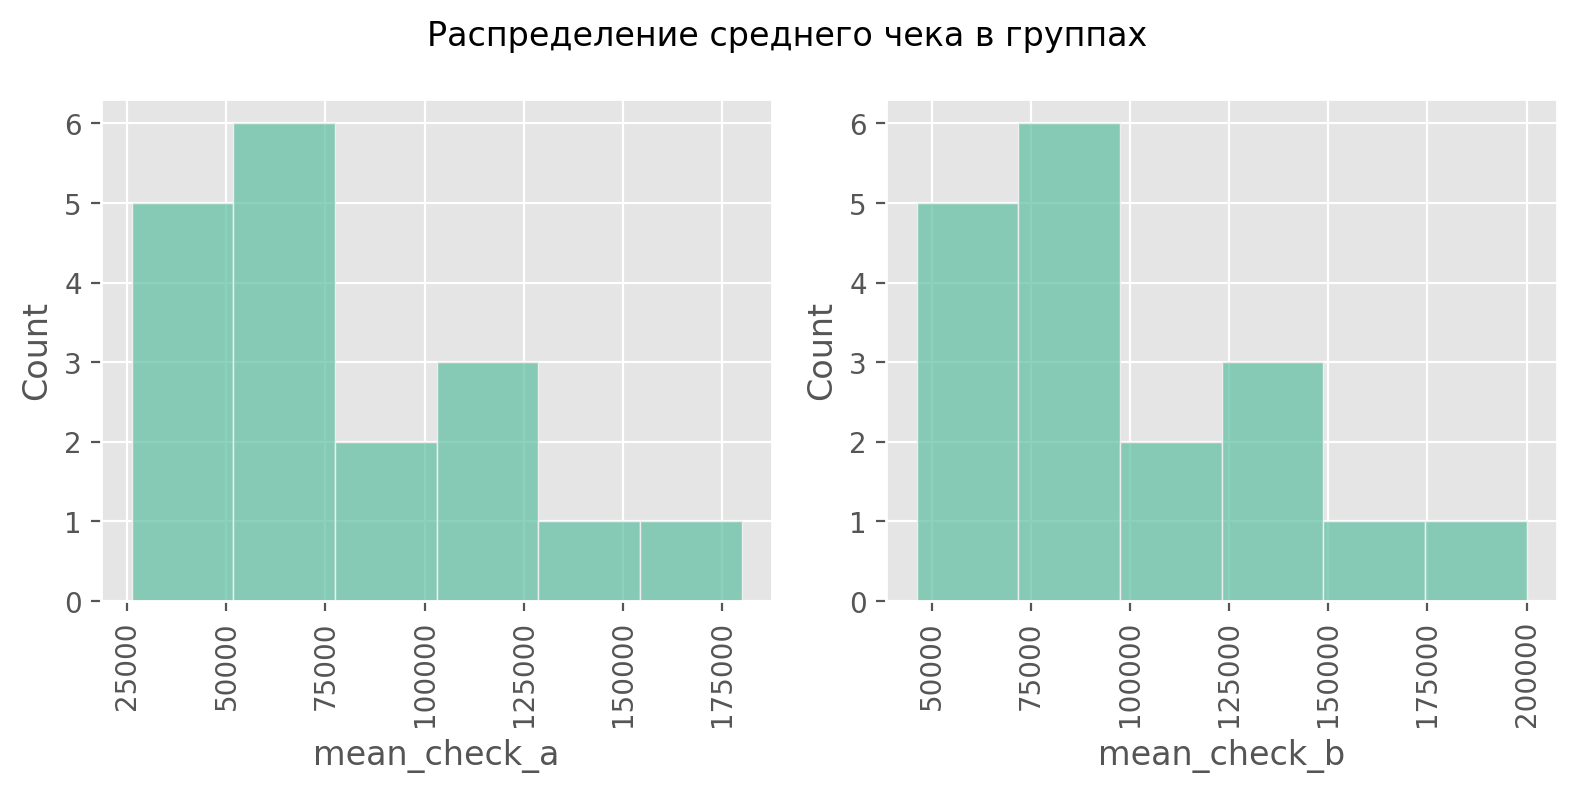

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(x='mean_check_a', data=check_data, label='a', fill=True, ax=ax[0])
sns.histplot(x='mean_check_b', data=check_data, label='b', fill=True, ax=ax[1])
fig.suptitle('Распределение среднего чека в группах')
for axis in ax:
    for label in axis.get_xticklabels():
        label.set_rotation(90)
plt.tight_layout()
plt.show()

Разница видна в пользу b, распределение выглядят как логнормальные.

# Произвожу проверку на нормальность

In [37]:
hd.shapiro_normal_test(check_data['mean_check_a'])
print()
hd.shapiro_normal_test(check_data['mean_check_b'])

Test on normal distribution: 0.8951390981674194
P-Value: 0.047312598675489426
NOT a normal distribution!

Test on normal distribution: 0.8946458697319031
P-Value: 0.04639303684234619
NOT a normal distribution!


In [38]:
hd.pirson_normal_test(check_data['mean_check_a'])
print()
hd.pirson_normal_test(check_data['mean_check_b'])

Test on normal distribution: 6.283213445993169
P-Value: 0.04321331027385417
Normal distribution

Test on normal distribution: 6.297805074142736
P-Value: 0.04289918130321666
Normal distribution


При уровне значимости 0.05 тест пирсона все же показывает что данные распределены нормлаьно, но ок, все-равно считаю что это не нормлаьное распределение и использую непараметрические тесты.

### U-тест Манна — Уитни

In [39]:
from scipy.stats import mannwhitneyu

In [40]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=check_data['mean_check_a'],
    y=check_data['mean_check_b'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.06
У нас нет оснований отвергнуть нулевую гипотезу


In [41]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=check_data['mean_check_a'],
    y=check_data['mean_check_b'],
    alternative='less' # изменили альтернативную гипотезу
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.03
Отвергаем нулевую гипотезу в пользу альтернативной
